In [28]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


In [29]:
np.random.seed(42)
torch.manual_seed(42)


In [ ]:
import torch
print(torch.version.cuda) 


None


In [31]:
# Load the CIFAR-10 dataset
(x_train_full, y_train_full), (x_test_full, y_test_full) = cifar10.load_data()

# Flatten label arrays
y_train_full = y_train_full.flatten()
y_test_full = y_test_full.flatten()

# Define the classes (cats and dogs)
class_map = {5: 'dog', 3: 'cat'}

# Filter training data
train_filter = np.isin(y_train_full, list(class_map.keys()))
x_train = x_train_full[train_filter]
y_train = y_train_full[train_filter]

# Filter test data
test_filter = np.isin(y_test_full, list(class_map.keys()))
x_test = x_test_full[test_filter]
y_test = y_test_full[test_filter]

# Map labels to +1 and -1
label_map = {5: 1, 3: -1}
y_train = np.vectorize(label_map.get)(y_train)
y_test = np.vectorize(label_map.get)(y_test)

# Flatten the images (32x32x3 -> 3072)
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# Convert to float32
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

# Scale the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


In [32]:
# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(x_train)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(x_test)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [33]:
from torch.utils.data import TensorDataset, DataLoader

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [34]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        x = torch.relu(self.hidden_layer(x))
        x = self.output_layer(x)
        return x


In [35]:
input_size = x_train.shape[1]  
hidden_size = 512  

model = MLP(input_size, hidden_size)


In [36]:
class HingeLoss(nn.Module):
    def __init__(self):
        super(HingeLoss, self).__init__()
    
    def forward(self, outputs, labels):
        # labels should be +1 or -1
        outputs = outputs.view(-1)
        labels = labels.view(-1)
        loss = torch.mean(torch.clamp(1 - outputs * labels, min=0))
        return loss


In [37]:
criterion = HingeLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)


In [38]:
num_epochs = 50
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * inputs.size(0)
        predictions = torch.sign(outputs).view(-1)
        correct += (predictions == labels.view(-1)).sum().item()
        total += labels.size(0)
    
    avg_loss = total_loss / total
    accuracy = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    
    # Evaluate on test data
    model.eval()
    total_loss_test = 0
    correct_test = 0
    total_test = 0
    
    for inputs_test, labels_test in test_loader:
        outputs_test = model(inputs_test)
        loss_test = criterion(outputs_test, labels_test)
        total_loss_test += loss_test.item() * inputs_test.size(0)
        predictions_test = torch.sign(outputs_test).view(-1)
        correct_test += (predictions_test == labels_test.view(-1)).sum().item()
        total_test += labels_test.size(0)
    
    avg_loss_test = total_loss_test / total_test
    accuracy_test = correct_test / total_test
    test_losses.append(avg_loss_test)
    test_accuracies.append(accuracy_test)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Train Acc: {accuracy*100:.2f}%, Test Loss: {avg_loss_test:.4f}, Test Acc: {accuracy_test*100:.2f}%")


Epoch 1/50, Train Loss: 0.9354, Train Acc: 56.10%, Test Loss: 0.8807, Test Acc: 58.35%
Epoch 2/50, Train Loss: 0.8778, Train Acc: 59.55%, Test Loss: 0.8597, Test Acc: 59.80%
Epoch 3/50, Train Loss: 0.8587, Train Acc: 60.26%, Test Loss: 0.8498, Test Acc: 60.35%
Epoch 4/50, Train Loss: 0.8437, Train Acc: 61.06%, Test Loss: 0.8422, Test Acc: 61.30%
Epoch 5/50, Train Loss: 0.8317, Train Acc: 61.92%, Test Loss: 0.8362, Test Acc: 61.50%
Epoch 6/50, Train Loss: 0.8216, Train Acc: 62.59%, Test Loss: 0.8287, Test Acc: 62.10%
Epoch 7/50, Train Loss: 0.8125, Train Acc: 63.41%, Test Loss: 0.8245, Test Acc: 62.55%
Epoch 8/50, Train Loss: 0.8046, Train Acc: 63.60%, Test Loss: 0.8211, Test Acc: 62.85%
Epoch 9/50, Train Loss: 0.7972, Train Acc: 64.25%, Test Loss: 0.8207, Test Acc: 63.35%
Epoch 10/50, Train Loss: 0.7900, Train Acc: 64.72%, Test Loss: 0.8196, Test Acc: 63.70%
Epoch 11/50, Train Loss: 0.7844, Train Acc: 65.27%, Test Loss: 0.8149, Test Acc: 63.55%
Epoch 12/50, Train Loss: 0.7780, Train Ac

In [39]:
# Get predictions on the training set
model.eval()
train_outputs = model(x_train_tensor)
train_predictions = torch.sign(train_outputs).view(-1)
train_labels = y_train_tensor.view(-1)
train_accuracy = (train_predictions == train_labels).sum().item() / train_labels.size(0)

# Get predictions on the test set
test_outputs = model(x_test_tensor)
test_predictions = torch.sign(test_outputs).view(-1)
test_labels = y_test_tensor.view(-1)
test_accuracy = (test_predictions == test_labels).sum().item() / test_labels.size(0)

print(f"\nFinal Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")



Final Training Accuracy: 77.42%
Final Test Accuracy: 65.50%


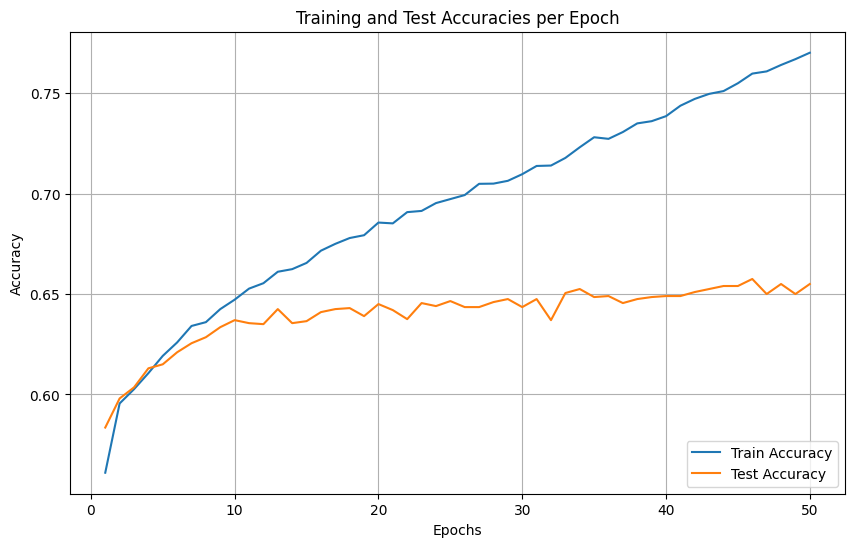

In [40]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies per Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


C:\Users\micro\AppData\Local\Temp\ipykernel_16140\2255191676.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label_names = [label_map_inv[int(label)] for label in sample_true_labels]


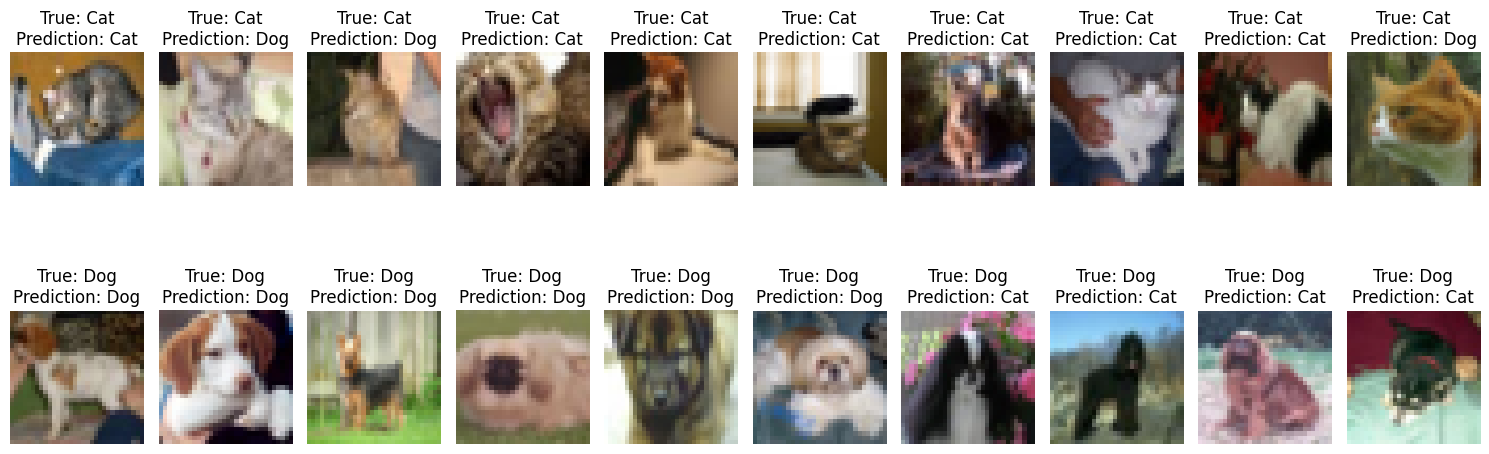

In [ ]:
import cupy as cp


y_pred_train_cpu = cp.asnumpy(train_predictions.detach())
y_pred_test_cpu = cp.asnumpy(test_predictions.detach())
y_train_cpu = cp.asnumpy(y_train_tensor.detach())
y_test_cpu = cp.asnumpy(y_test_tensor.detach())




cat_indices = np.where(y_test_cpu == -1)[0]  
dog_indices = np.where(y_test_cpu == 1)[0]   

# Select the first 10 cats and 10 dogs (or use random.choice if you want them shuffled)
cat_indices = cat_indices[:10]
dog_indices = dog_indices[:10]

# Combine and ensure consistent order (cats followed by dogs)
selected_indices = np.concatenate([cat_indices, dog_indices])

# Get the images, true labels, and predicted labels
sample_images = x_test[selected_indices]
sample_true_labels = y_test_cpu[selected_indices]
sample_pred_labels = y_pred_test_cpu[selected_indices]

# Map labels back to class names
label_map_inv = {1: 'Dog', -1: 'Cat'}
true_label_names = [label_map_inv[int(label)] for label in sample_true_labels]
pred_label_names = [label_map_inv[int(label)] for label in sample_pred_labels]

# Reverse scaling to get original pixel values
sample_images_np = sample_images  # Convert CuPy to NumPy
sample_images_original = scaler.inverse_transform(sample_images_np)

# Plot the images
plt.figure(figsize=(15, 6))
for idx in range(len(selected_indices)):
    plt.subplot(2, len(selected_indices) // 2, idx + 1)
    image = sample_images_original[idx].reshape(32, 32, 3)
    image = np.clip(image, 0, 255).astype('uint8')
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"True: {true_label_names[idx]}\nPrediction: {pred_label_names[idx]}")
plt.tight_layout()
plt.show()
